In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['Aaberg', 'Aalst', 'Aara', 'Aaren', 'Aarika', 'Aaron', 'Aaronson', 'Ab']

In [3]:
import urllib
words = urllib.request.urlopen(
    'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'
    ).read().decode('utf-8').splitlines()

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [8]:
X[:5]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])

In [9]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [10]:
C = torch.randn((27, 2))

In [11]:
emb = C[X]
emb.shape , X.shape

(torch.Size([228146, 3, 2]), torch.Size([228146, 3]))

In [12]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [13]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [14]:
h

tensor([[ 1.0000, -1.0000,  0.6642,  ..., -0.9876,  0.9997,  0.5405],
        [ 1.0000, -1.0000,  0.4748,  ..., -0.8131,  0.9994,  0.4930],
        [ 1.0000, -1.0000,  0.9454,  ..., -0.9623,  0.9986,  0.2489],
        ...,
        [-0.8826,  0.9999, -1.0000,  ...,  1.0000, -0.9869, -1.0000],
        [ 0.8890,  0.9487, -1.0000,  ...,  1.0000, -0.9919, -0.9996],
        [ 0.0620,  0.8713, -1.0000,  ...,  0.9861, -0.8954, -1.0000]])

In [15]:
h.shape

torch.Size([228146, 100])

In [16]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [17]:
logits = h @ W2 + b2

In [18]:
logits.shape

torch.Size([228146, 27])

In [19]:
counts = logits.exp()

In [20]:
prob = counts / counts.sum(1, keepdims=True)

In [21]:
prob.shape

torch.Size([228146, 27])

In [22]:
Y.shape

torch.Size([228146])

In [23]:
loss = -prob[torch.arange(228146), Y].log().mean()
loss

tensor(14.9329)

In [24]:
# ------------ now made respectable :) ---------------

In [25]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [26]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [27]:
emb.shape , emb.view(-1,emb.shape[1]*emb.shape[2]).shape 
# Flattening the 2nd and 3rd dim . (Each word has 2 dim , and we use block size as 3 so 3*2)

(torch.Size([228146, 3, 2]), torch.Size([228146, 6]))

In [28]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [29]:
for p in parameters:
  p.requires_grad = True

In [30]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [31]:
lri = []
lossi = []
stepi = []

In [32]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  hpreact = emb.view(-1, 30) @ W1 + b1
  h = torch.tanh(hpreact) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

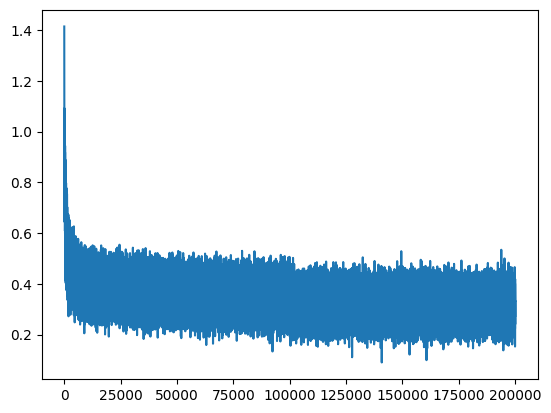

In [33]:
plt.plot(stepi, lossi)

In [34]:
emb = C[Xtr] # (32, 3, 2)
hpreact = emb.view(-1, 30) @ W1 + b1
h = torch.tanh(hpreact) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1211, grad_fn=<NllLossBackward0>)

In [35]:
h.shape

torch.Size([182625, 200])

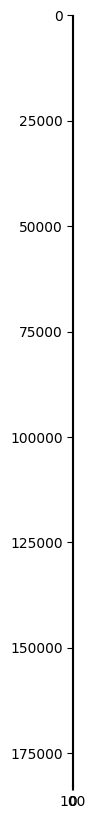

In [36]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99 ,cmap = 'gray' , interpolation='nearest')

(array([14822252.,  1001282.,   603484.,   503953.,   458479.,   466412.,
          473312.,   592555.,   951978., 16651293.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

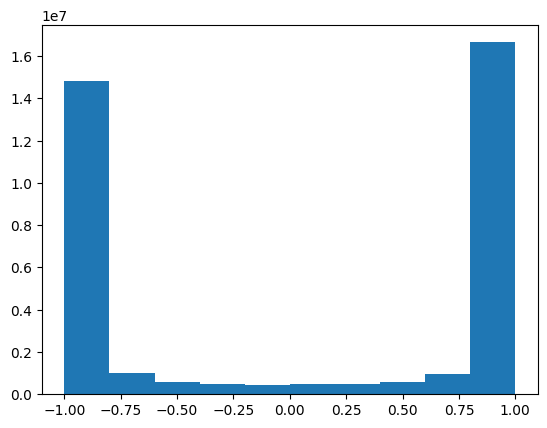

In [37]:
plt.hist(h.view(-1).tolist())

(array([7.3440000e+03, 1.9997200e+05, 1.1521140e+06, 5.4528480e+06,
        1.0717826e+07, 1.0699577e+07, 6.5220380e+06, 1.5958750e+06,
        1.6812400e+05, 9.2820000e+03]),
 array([-20.76387024, -16.59798374, -12.43209724,  -8.26621075,
         -4.10032425,   0.06556225,   4.23144875,   8.39733524,
         12.56322174,  16.72910824,  20.89499474]),
 <BarContainer object of 10 artists>)

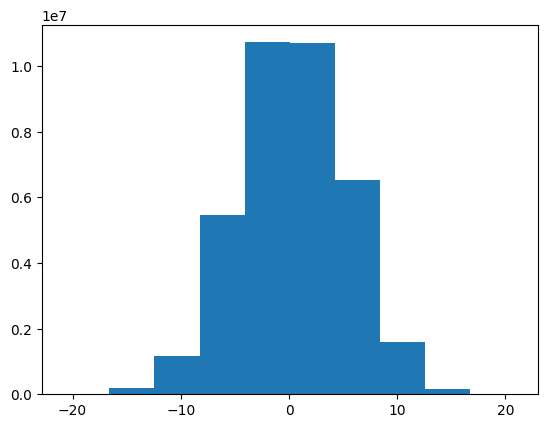

In [38]:
plt.hist(hpreact.view(-1).tolist())

In [39]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1559, grad_fn=<NllLossBackward0>)

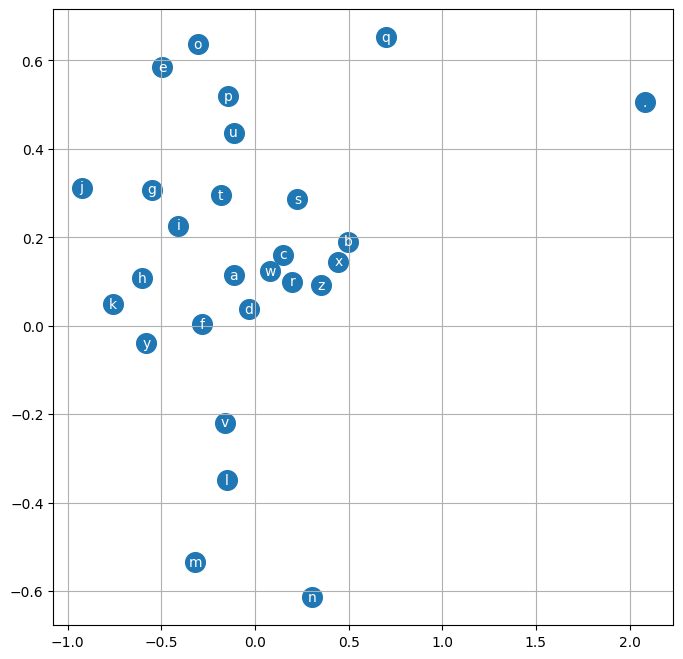

In [40]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [41]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [42]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [43]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlah.
amelle.
khy.
mili.
taty.
skaelane.
rahnen.
den.
rha.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
jorn.
quinn.
sulin.
alianni.
wajelo.
dearysia.
